# SARIMA for EPS (Earnings per share) Johnson & Johnson

Importing libraries

In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

import pandas as pd

import numpy as np

from tqdm import tqdm_notebook

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [10, 7.5]

In [3]:
#Import Data

data = pd.read_csv('jj.csv')

data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


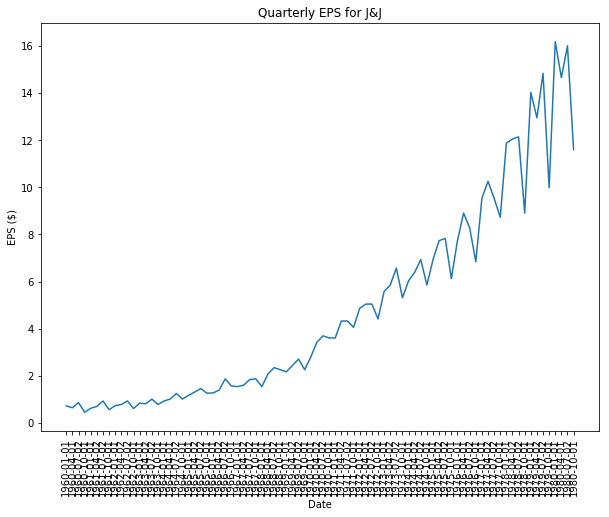

In [4]:
plt.plot(data['date'], data['data'])
plt.title('Quarterly EPS for J&J')
plt.ylabel('EPS ($)')
plt.xlabel('Date')
plt.xticks(rotation = 90)
plt.show()

It can be seen that there is an increasing trend with time, showing that the time-series is not stationary.

To make it stationary and fit a model to make predictions, we will apply the log-difference transformation to the data-set.

In [5]:
#Need to make it stationary (log-difference)

data['data_tr_1'] = np.log(data['data'])
data['data_tr_1'] = data['data_tr_1'].diff()

data.head()

,date,data,data_tr_1
0,1960-01-01,0.71,NaN
1,1960-04-01,0.63,-0.119545
2,1960-07-02,0.85,0.299517
3,1960-10-01,0.44,-0.658462
4,1961-01-01,0.61,0.326684


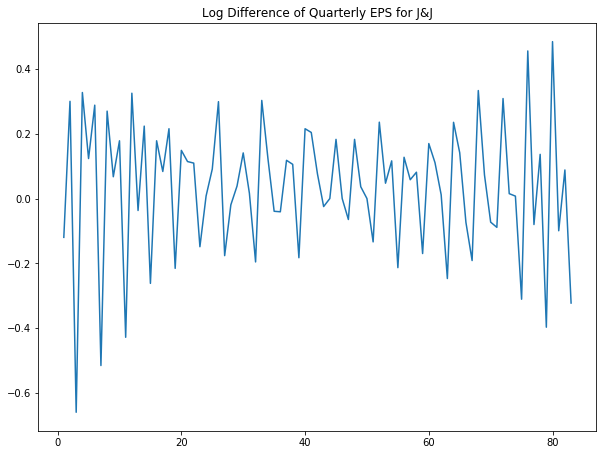

In [7]:
plt.plot(data['data_tr_1'][1:])
plt.title('Log Difference of Quarterly EPS for J&J')
plt.show()

After applying log-transformations it can be seen that the data seems to have become stationary. But the variance still seems quite high.

To reduce the variance, we will take the seasonal difference. Since the data is quarterly, we will take difference with the last 4 values.

In [8]:
#To reduce the variance, we will take seasonal difference
data['data_tr_2'] = data['data_tr_1'][1:].diff(4)  #m = 4 (Quarterly difference), no.of points in a season
data.head(15)

,date,data,data_tr_1,data_tr_2
0,1960-01-01,0.71,NaN,NaN
1,1960-04-01,0.63,-0.119545,NaN
2,1960-07-02,0.85,0.299517,NaN
3,1960-10-01,0.44,-0.658462,NaN
4,1961-01-01,0.61,0.326684,NaN
5,1961-04-02,0.69,0.123233,0.242778
6,1961-07-02,0.92,0.287682,-0.011834
7,1961-10-01,0.55,-0.514455,0.144006
8,1962-01-01,0.72,0.269333,-0.057351
9,1962-04-02,0.77,0.067139,-0.056093


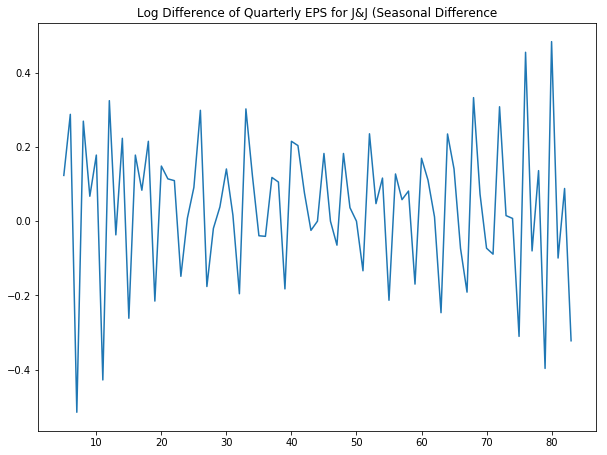

In [9]:
plt.plot(data['data_tr_1'][5:])
plt.title('Log Difference of Quarterly EPS for J&J (Seasonal Difference')
plt.show()

It can be seen the variance has now gone down and the time-series looks more or less stationary. But just to make sure that we actually have a time series, we will perform the Augmented Dicky Fuller test.

In [10]:

ad_fuller_result = adfuller(data['data_tr_2'][5:])

print(f'ADF Statistic: {ad_fuller_result[0]}')

print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.630805109914266
p-value: 5.721578695136168e-09


Since the p-value is less than 0.05, we can reject the null-hypothesis and establish that the time-series is stationary and we can start fitting our model.

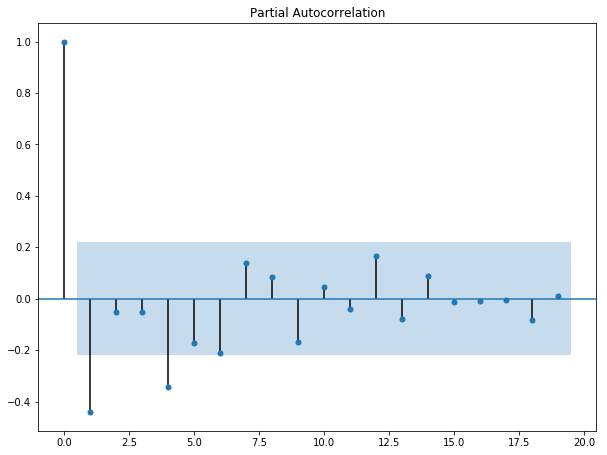

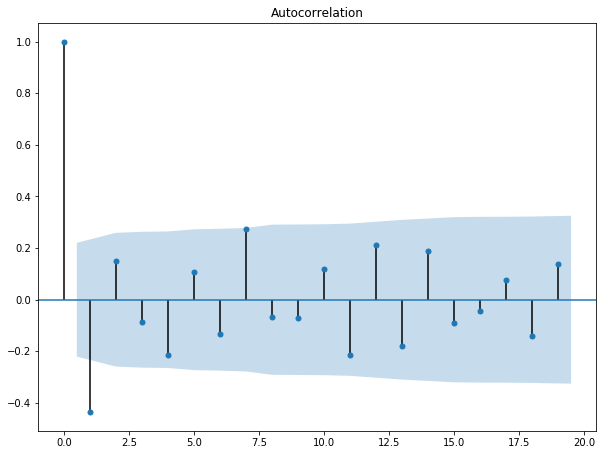

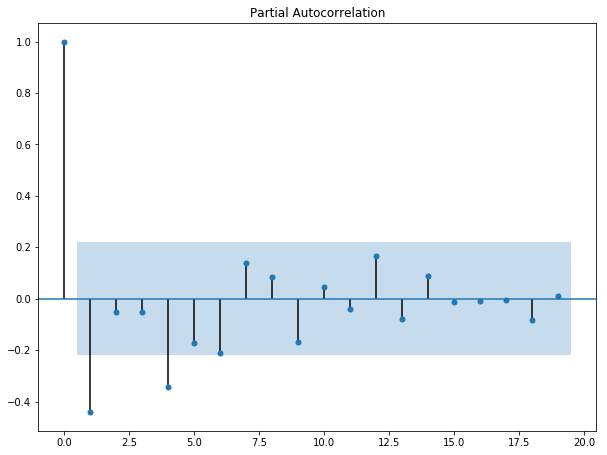

In [11]:
plot_acf(data['data_tr_2'][5:])
plot_pacf(data['data_tr_2'][5:])

Since the ACF and PACF are still decaying, the model that can fit the data is neither the Moving-Average nor Autoregressive model. Let's try to fit the SARIMA model with differencing (d) as 1 and seasonal differencing, D, as 1 (since we took a seasonal difference of 4 earlier).

The next task is to estimate p,q (the ARIMA parameters) and P, Q (the seasonal parameters).

For this, we will be writing an optimization function which will fit the entire dataset from a range of p, q, P, and Q combination values. It will then calculate AIC for each legitimate combination value. From that we will be selecting the optimum combination of values.

In [12]:
def optimize_SARIMA(endog, parameters_list, d, D, s):
    """
    Returns a data-frame with parameters and corresponding AIC

    endog - the observed variable
    parameters_list - list with (p,q,P,Q) tuples
    d - integration (differencing order)
    D - seasonal integration order
    s - length of season
    """

    results = []

    for param in tqdm_notebook(parameters_list):

        try:
            model = SARIMAX(endog, 
            order = (param[0], d, param[1]),
            seasonal_order = (param[2], D, param[3], s),
            simple_differencing = False).fit(disp = False)

        except:
            continue

        aic = model.aic
        results.append([param, aic])

    result_df = pd.DataFrame(results)

    result_df.columns = ['(p,q)x(P,Q)', 'AIC']

    result_df = result_df.sort_values(by = 'AIC', ascending = True).reset_index(drop = True)

    return result_df 

Now, we will generate the parameters that have to be passed to the optimization function.

In [13]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4

parameters = product(p, q , P, Q)

parameters_list = list(parameters)


Let's run the optimization

In [14]:
result_df = optimize_SARIMA(data['data'], parameters_list, 1, 1, 4)

  0%|          | 0/256 [00:00<?, ?it/s]

In [15]:
result_df.head()

,"(p,q)x(P,Q)",AIC
0,"(2, 3, 0, 0)",92.586641
1,"(2, 3, 1, 0)",93.975631
2,"(3, 2, 1, 2)",94.082435
3,"(2, 3, 0, 1)",94.132058
4,"(3, 3, 0, 0)",94.473696


Based on AIC, (p,d,q, P,D,Q) = (2,1,3,0,1,0) m = 4

We will now fit the model based on these optimum parameters

In [17]:
#Now fitting the best model after finding the hyperparameters
best_model = SARIMAX(data['data'], order = (2,1,3), seasonal_order = (0, 1, 0, 4), simple_differencing = False)
res = best_model.fit(disp = False)

In [18]:
print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               data   No. Observations:                   84
Model:             SARIMAX(2, 1, 3)x(0, 1, [], 4)   Log Likelihood                 -40.293
Date:                            Mon, 20 Sep 2021   AIC                             92.587
Time:                                    13:15:32   BIC                            106.803
Sample:                                         0   HQIC                            98.282
                                             - 84                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4846      0.116    -12.815      0.000      -1.712      -1.258
ar.L2         -0.7904      0.131   

Let us make some diagnostic curves to see the performance of the fitted model

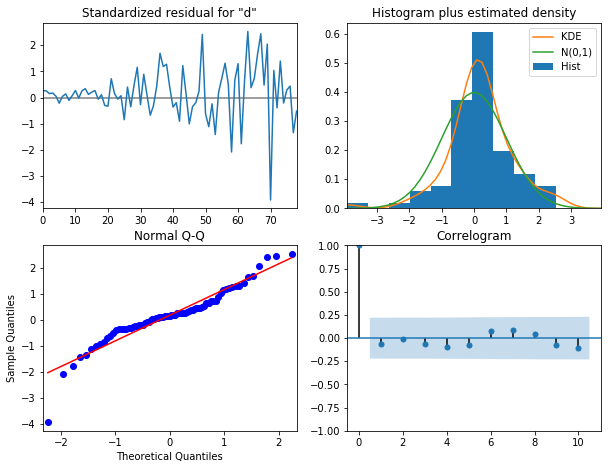

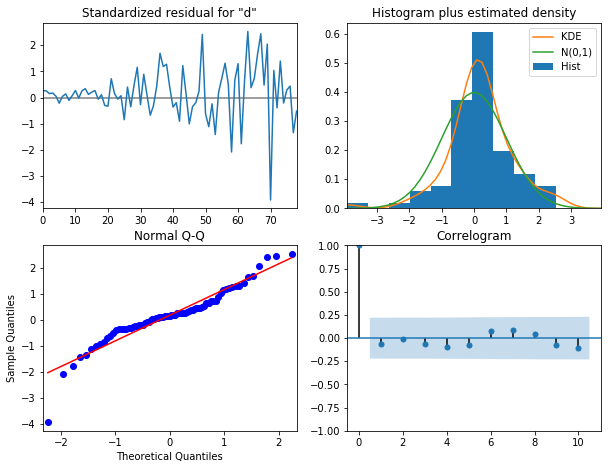

In [19]:
res.plot_diagnostics()

The residual diagnostics look pretty good. The residuals are normally distributed, which can be seen from the distributions and quartile-quartile curves.

We will now be predicting the ESPs for the next 8 quarters

[Text(0.5, 1.0, 'Forecast of Quarterly EPS for J&J')]

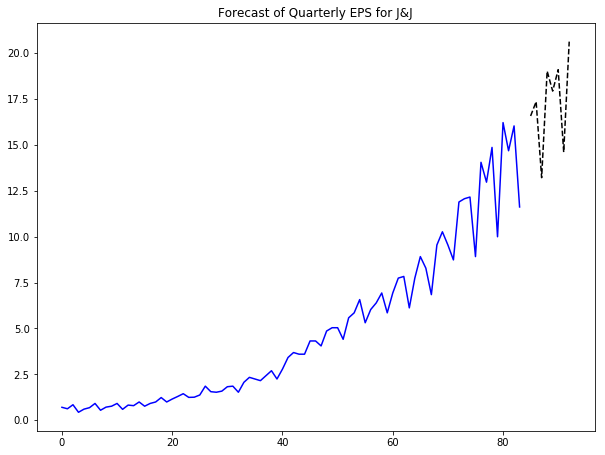

In [20]:
#Forecasting 8 steps
n_forecast = 8 #Predicting next two years (8 quarters)

predict = res.get_prediction(end = best_model.nobs + n_forecast)

idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots()

ax.plot(data['data'], 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title = 'Forecast of Quarterly EPS for J&J')

The black-line depicts the predictions of 8 quarters after the observations (depicted in blue)

In [21]:
data['model'] = predict.predicted_mean

data.head(15)

,date,data,data_tr_1,data_tr_2,model
0,1960-01-01,0.71,NaN,NaN,0.000000
1,1960-04-01,0.63,-0.119545,NaN,0.710000
2,1960-07-02,0.85,0.299517,NaN,0.630000
3,1960-10-01,0.44,-0.658462,NaN,0.850000
4,1961-01-01,0.61,0.326684,NaN,0.795000
5,1961-04-02,0.69,0.123233,0.242778,0.530000
6,1961-07-02,0.92,0.287682,-0.011834,0.804951
7,1961-10-01,0.55,-0.514455,0.144006,0.482654
8,1962-01-01,0.72,0.269333,-0.057351,0.645347
9,1962-04-02,0.77,0.067139,-0.056093,0.748546


In [22]:
mse = mean_squared_error(data['data'], data['model'])

print(f'MSE: {mse}')

MSE: 0.1561250997148766


The mean-squared error is 0.156, which is pretty low. This proves that our SARIMA model is highly accurate.

Let's see how our model looks like on the given data-set

Text(0.5, 1.0, 'J&J Quarterly EPS')

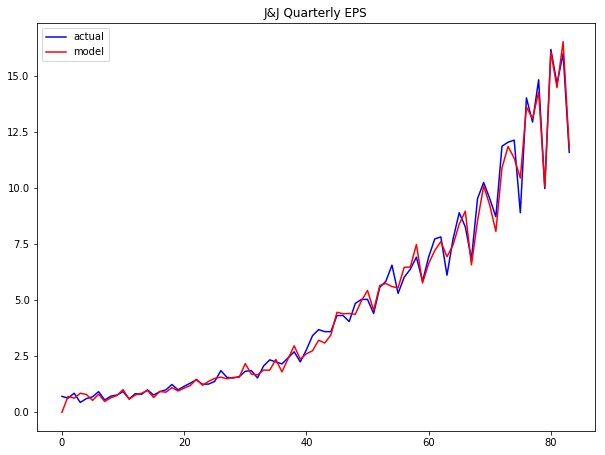

In [23]:
plt.plot(data['data'], color = 'blue', label  ='actual')
plt.plot(data['model'], color = 'red', label = 'model')
plt.legend(loc = 'best')
plt.title('J&J Quarterly EPS')

This shows that our model simulates the given time-series data quite nicely.